In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

#### Loading the retweet networks

In [2]:
# Reading data
basepath = '../../data/network_data'

before_data = pd.read_csv(os.path.join(basepath, 'before_campaign_representative.graph'))
during_data = pd.read_csv(os.path.join(basepath, 'campaign_representative.graph'))
after_data = pd.read_csv(os.path.join(basepath, 'after_elections_representative.graph'))

# Forcing the conversion to string
before_data['source'] = before_data['source'].astype(str)
before_data['target'] = before_data['target'].astype(str)
during_data['source'] = during_data['source'].astype(str)
during_data['target'] = during_data['target'].astype(str)
after_data['source'] = after_data['source'].astype(str)
after_data['target'] = after_data['target'].astype(str)

# Shapes
print("Before data has shape: ", before_data.shape)
print("During data has shape: ", during_data.shape)
print("After data has shape: ", after_data.shape)

Before data has shape:  (72716, 3)
During data has shape:  (92920, 3)
After data has shape:  (91749, 3)


In [3]:
# Creating graphs
# use nx.DIGraph() for directed graph
before_graph = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
during_graph = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
after_graph = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

# Some basic stats
print("Before graph has: ", before_graph.number_of_nodes(), " nodes and ", before_graph.number_of_edges(), " edges")
print("During graph has: ", during_graph.number_of_nodes(), " nodes and ", during_graph.number_of_edges(), " edges")
print("After graph has: ", after_graph.number_of_nodes(), " nodes and ", after_graph.number_of_edges(), " edges")

Before graph has:  34863  nodes and  72576  edges
During graph has:  46388  nodes and  92711  edges
After graph has:  66500  nodes and  91689  edges


#### Community detection via the Louvain algorithm

In [6]:
print("Running community detection algorithms on the 'Before graph'")
before_comms = nx.community.louvain_communities(before_graph, weight='weight', seed=123)

print("Running community detection algorithms on the 'During graph'")
during_comms = nx.community.louvain_communities(during_graph, weight='weight', seed=123)

print("Running community detection algorithms on the 'After graph'")
after_comms = nx.community.louvain_communities(after_graph, weight='weight', seed=123)

Running community detection algorithms on the 'Before graph'
Running community detection algorithms on the 'During graph'
Running community detection algorithms on the 'After graph'


In [7]:
print("Before graph has: ", len(before_comms), " communities")
print("During graph has: ", len(during_comms), " communities")
print("After graph has: ", len(after_comms), " communities")

Before graph has:  9  communities
During graph has:  15  communities
After graph has:  17  communities


In [8]:
print(nx.community.modularity(before_graph, before_comms))
print(nx.community.modularity(during_graph, during_comms))
print(nx.community.modularity(after_graph, after_comms))

0.6491696320714566
0.6777822896171288
0.6324620380524457


In [9]:
output_path = "../../results/louvain_communities"

#store the comms
pickle.dump(before_comms, open(os.path.join(output_path, 'before_comms.pickle'), 'wb'))
pickle.dump(during_comms, open(os.path.join(output_path, 'during_comms.pickle'), 'wb'))
pickle.dump(after_comms, open(os.path.join(output_path, 'after_comms.pickle'), 'wb'))

#### Community analysis

##### Size

In [10]:
before_comm_sizes = [len(comm) for comm in before_comms]
during_comm_sizes = [len(comm) for comm in during_comms]
after_comm_sizes = [len(comm) for comm in after_comms]

In [11]:
print(np.quantile(before_comm_sizes, [0.25, 0.5, 0.75, .8, .9]))
print(np.quantile(during_comm_sizes, [0.25, 0.5, 0.75, .8, .9]))
print(np.quantile(after_comm_sizes, [0.25, 0.5, 0.75, .8, .9]))

[ 640.  4444.  5698.  5998.4 7018. ]
[2.00000e+00 3.00000e+00 5.31600e+03 6.46080e+03 1.10146e+04]
[2.0000e+00 5.0000e+00 3.1110e+03 6.0926e+03 7.3412e+03]


Text(0, 0.5, 'Frequency')

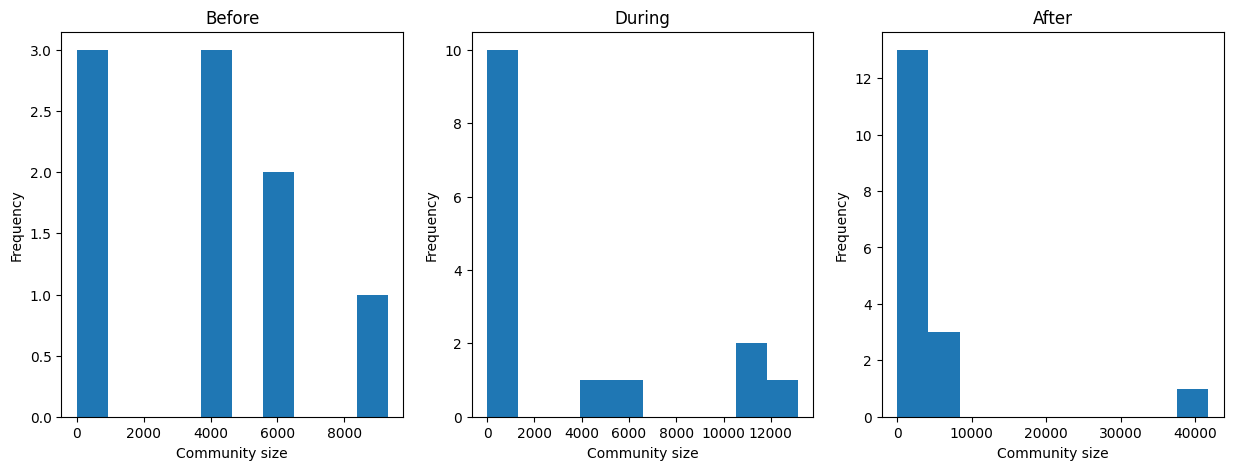

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(before_comm_sizes) #, bins=100
ax[0].set_title("Before")
ax[0].set_xlabel("Community size")
ax[0].set_ylabel("Frequency")

ax[1].hist(during_comm_sizes) #, bins=100
ax[1].set_title("During")
ax[1].set_xlabel("Community size")
ax[1].set_ylabel("Frequency")

ax[2].hist(after_comm_sizes) #, bins=100
ax[2].set_title("After")
ax[2].set_xlabel("Community size")
ax[2].set_ylabel("Frequency")

##### Quality: Modularity | Coverage | Conductance

In [13]:
print(nx.community.modularity(before_graph, before_comms))
print(nx.community.modularity(during_graph, during_comms))
print(nx.community.modularity(after_graph, after_comms))

0.6491696320714566
0.6777822896171288
0.6324620380524457


In [14]:
# coverage, performance

# coverage is the ratio of the number of intra-community edges by the total number of edges.
# by definition, an ideal cluster structure, where the clusters are disconnected 
# from each other, yields a coverage of 1, as all edges of the graph fall within clusters.

# performance counts the number of correctly “interpreted” pairs of vertices,
# i.e. two vertices belonging to the same community and connected by an edge, 
# or two vertices belonging to different communities and not connected by an edge.
print(nx.community.partition_quality(before_graph, before_comms))
print(nx.community.partition_quality(during_graph, during_comms))
print(nx.community.partition_quality(after_graph, after_comms))

(0.759713955026455, 0.8234479612406416)
(0.8605451348815135, 0.7817164922633271)
(0.901329494268669, 0.5678586340887934)


In [15]:
def eval_conductance(graph, communities):
    conductance = np.zeros([len(communities), len(communities)])
    for i, comm_i in enumerate(communities):
        for j, comm_j in enumerate(communities):
            conductance[i, j] = nx.algorithms.cuts.conductance(graph, comm_i, comm_j, weight='weight')
    return conductance

In [16]:
# conductance
before_conductance = eval_conductance(before_graph, before_comms)
during_conductance = eval_conductance(during_graph, during_comms)
after_conductance = eval_conductance(after_graph, after_comms)

In [17]:
# average conductance
print(np.mean(before_conductance))
print(np.mean(during_conductance))
print(np.mean(after_conductance))

0.06845069823519337
0.0383552859499515
0.03352046753469109


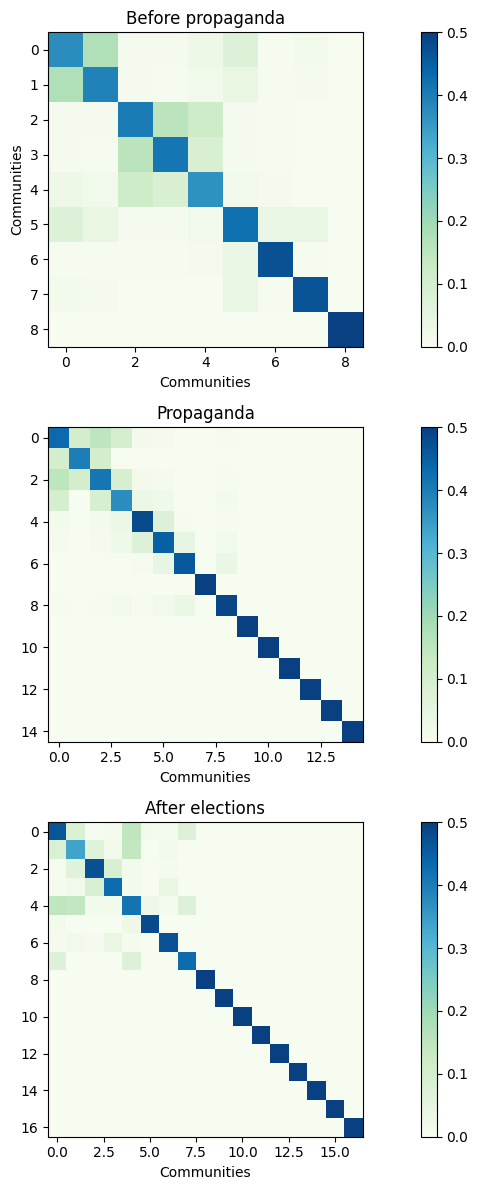

In [18]:
# plot the conductance matrix with a heatmap
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

im_b = ax[0].imshow(before_conductance, cmap='GnBu')
cbar_b = ax[0].figure.colorbar(im_b)

im_d = ax[1].imshow(during_conductance, cmap='GnBu')
cbar_d = ax[1].figure.colorbar(im_d)

im_a = ax[2].imshow(after_conductance, cmap='GnBu')
cbar_a = ax[2].figure.colorbar(im_a)

ax[0].set_title("Before propaganda")
ax[1].set_title("Propaganda")
ax[2].set_title("After elections")

ax[0].set_xlabel("Communities")
ax[0].set_ylabel("Communities")

ax[1].set_xlabel("Communities")
ax[2].set_xlabel("Communities")

fig.tight_layout()